 
    
**Название проекта**
Анализ воронки продаж и применение ААВ-тестирования

**Описание исследования.**
Вы работаете в стартапе, который продаёт продукты питания. 
Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

**Цель исследования.**

Изучить и проанализировать поведение пользователей
По результатам A/A/B-эксперимента "изменение шрифта" понять влияет ли новый шрифт на поведеие пользователей.

**Задачи исследования.** 

Изучите и проверьте данные:
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
- Много ли событий и пользователей вы потеряли, отбросив старые данные?
- Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

Изучите воронку событий:
- Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
- Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
- Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
- По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- На каком шаге теряете больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

Изучите результаты эксперимента
- Сколько пользователей в каждой экспериментальной группе?
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

**Исходные данные.**

Каждая запись в логе — это действие пользователя, или событие. \
EventName — название события;\
DeviceIDHash — уникальный идентификатор пользователя;\
EventTimestamp — время события;\
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.



## Открываем файл, изучаем общую информацию

In [1]:
# импорт библиотек
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
import math as mth

In [2]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('logs_exp.csv', sep='\t')

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Выполним предобработку данных


### Добавлю столбец с датой и временим и отдельно только с датой

In [8]:
df['Date_Time'] = pd.to_datetime(df['EventTimestamp'], unit = 's')
df['Date'] = df['Date_Time'].astype('datetime64[D]')
df

,EventName,DeviceIDHash,EventTimestamp,ExpId,Date_Time,Date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


### Выполню проверку на дубликаты

In [9]:
df.duplicated().sum()

413

In [10]:
#удаляю дубликаты
df = df.drop_duplicates()
#смотрю что ничего лишнего не удалилось
df.shape[0]

243713

In [13]:
#обновлю индексы после удаления дубликатов
df.reset_index(drop= True , inplace= True )
df

,EventName,DeviceIDHash,EventTimestamp,ExpId,Date_Time,Date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


### Выполю проверку на пропуск

In [14]:
df.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
Date_Time         0
Date              0
dtype: int64

### Проверка есть ли пользователи попавшие в обе группы

In [15]:
a_b_users = df.groupby('DeviceIDHash').agg({'ExpId' : 'nunique'}).query('ExpId>1').count()
a_b_users

ExpId    0
dtype: int64

Вывод: В процессе предобработки были добавлены 2 столбца - с датой и с датой и временем.\
выполена проверка на дубликаты - удалено 413\
выполнена проверка на пропуски - пропусков нет\
проверка есть ли пользователи, попавшие в обе группы - таких нет

## Изучение и проверка данных

### Сколько всего событий в логе

In [16]:
print('Всего событий:',df.shape[0])

Всего событий: 243713


### Сколько всего пользователей в логе

In [17]:
print('Всего пользователей:',df['DeviceIDHash'].nunique())

Всего пользователей: 7551


### Сколько в среднем событий приходится на пользователя

In [18]:
print('В среднем событий на пользователя:', "{0:.1f}".format(df.shape[0]/df['DeviceIDHash'].nunique()))

В среднем событий на пользователя: 32.3


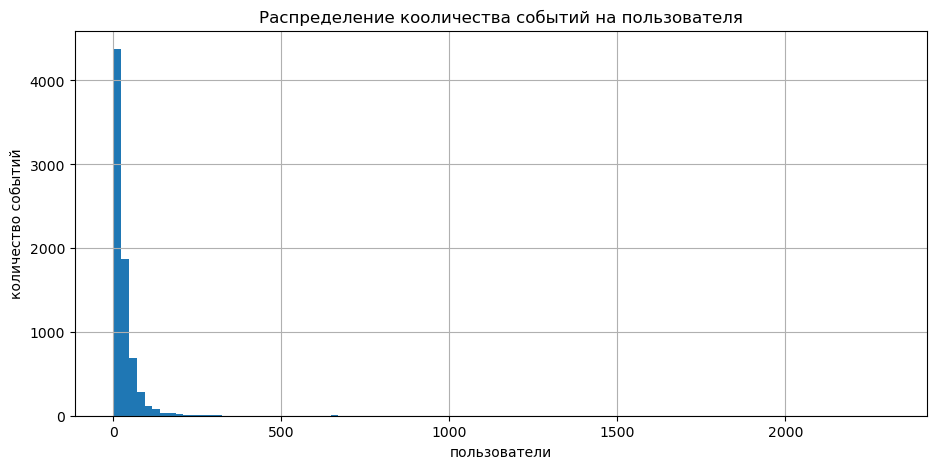

In [26]:
#сгруппирую пользователей по количеству событий и построю гистограмму
plt.figure(figsize=(11,5))
event_users = df.groupby('DeviceIDHash')['EventName'].count().sort_values()
event_users.hist(bins=100)
plt.title('Распределение кооличества событий на пользователя')
plt.xlabel('пользователи')
plt.ylabel('количество событий')
plt.show()

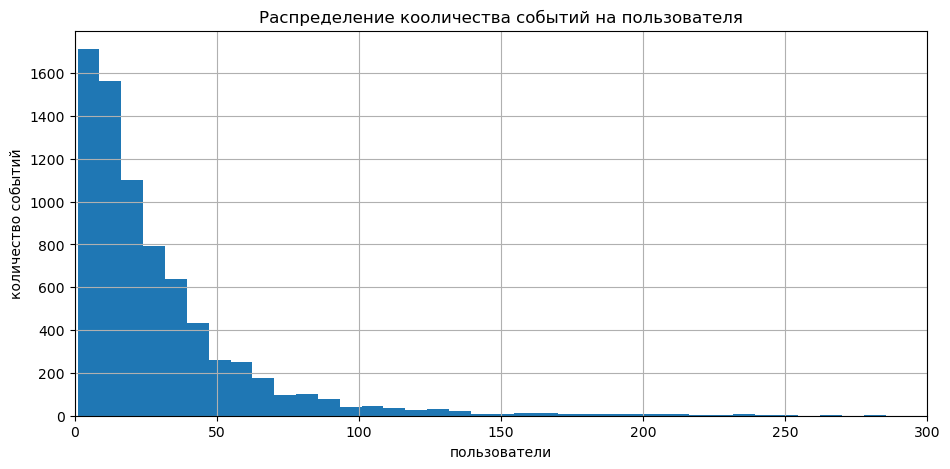

In [27]:
# увеличим масштаб
plt.figure(figsize=(11,5))
event_users.hist(bins=300)
plt.xlim(0,300)
plt.title('Распределение кооличества событий на пользователя')
plt.xlabel('пользователи')
plt.ylabel('количество событий')
plt.show()

Явно есть пользователи которые супер активно пользуются приложением и их чуть больше 50. 

### Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [29]:
print('Максимальная дата',df['Date'].max())
print('Минимальная дата',df['Date'].min())

Максимальная дата 2019-08-07 00:00:00
Минимальная дата 2019-07-25 00:00:00


#### Гистограмма по дате и врмени

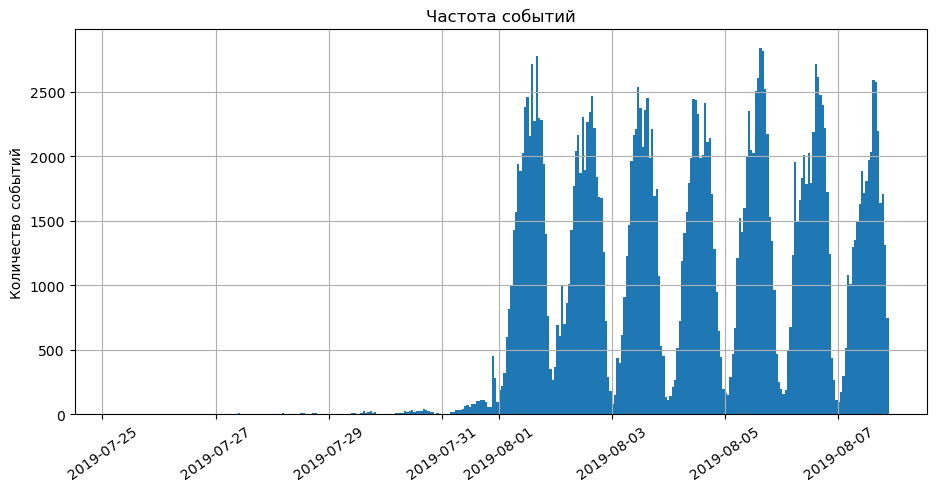

In [28]:
plt.figure(figsize=(11,5))

df['Date_Time'].hist(bins=14*24) # 14 дней по 24 часа

plt.title('Частота событий')

plt.xticks(rotation=35)
plt.ylabel('Количество событий')
plt.show() 

In [17]:
#Сгруппирую данные чтобы точнее оценить период
df.groupby('Date')['EventName'].count()

Date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      412
2019-07-31     2030
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
Name: EventName, dtype: int64

Данные за первую неделю неполные.
Видно сильное изменение в количестве событий начиная с 1 августа. Располагаем периодом с 01-08 по 07-08. Сделаем сред с данными за вторую неделю

In [30]:
df_sw = df[df['Date'] > '2019-07-31']


In [31]:
df_sw.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId,Date_Time,Date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


### Много ли событий и пользователей вы потеряли, отбросив старые данные

In [32]:
print('Потеряно уникальных событий:', df['EventName'].nunique() - df_sw['EventName'].nunique())
print('Потеряно уникальных пользователей:', df['DeviceIDHash'].nunique() - df_sw['DeviceIDHash'].nunique(), \
      ', что составляет {:.2%}'.format((df['DeviceIDHash'].nunique()\
                                        - df_sw['DeviceIDHash'].nunique())/(df['DeviceIDHash'].nunique())))
print('Всего удалено строк:',df.shape[0] - df_sw.shape[0],\
      ', что составляет {:.2%}'.format((df.shape[0] - df_sw.shape[0])/df.shape[0]))

Потеряно уникальных событий: 0
Потеряно уникальных пользователей: 17 , что составляет 0.23%
Всего удалено строк: 2826 , что составляет 1.16%


### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [33]:
df_sw.groupby('ExpId')['DeviceIDHash'].nunique()

ExpId
246    2484
247    2513
248    2537
Name: DeviceIDHash, dtype: int64

Вывод: далее работа будет продолжаться с новым срезом куда попали данные за втроую неделю. Данные за первую неделю не полные их количество в разы отличается от объема данным за вторую неделю. В новый срез не попал 1,16% всех данных и менее 1% уникальных пользователей

## Изучите воронку событий

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте

In [34]:
df_sw.groupby('EventName')['Date_Time'].count().sort_values()

EventName
Tutorial                     1005
PaymentScreenSuccessful     33918
CartScreenAppear            42303
OffersScreenAppear          46333
MainScreenAppear           117328
Name: Date_Time, dtype: int64

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие

In [35]:
#скольо пользователей совершали каждое из событий
event = df_sw.groupby('EventName')['DeviceIDHash'].nunique().sort_values(ascending=False).reset_index()
#добавлю столбец с процентом от всех пользователей
event['%_of_all_users'] = (event['DeviceIDHash']/df_sw['DeviceIDHash'].nunique()*100).round(2)
event

,EventName,DeviceIDHash,%_of_all_users
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Предполагаю, что события выстраиваются в следующей последовательности:\
1 - MainScreenAppear - основной экран\
2 - OffersScreenAppear - экран с товарами\
3 - CartScreenAppear - экран корзины\
4 - PaymentScreenSuccessful - экран с окном "успешная оплата"

Обучающий экран - Tutorial - используют 11% пользователей, думаю, что на него переходят по специальной кнопке, если в этом есть необходимость 


### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.


In [24]:
#уберем из расчетов строчку с туториалом
event_no_tutorial = event[event['EventName'] != 'Tutorial']

event_no_tutorial['%_to_next_step'] = \
    round(event_no_tutorial['DeviceIDHash']*100/event_no_tutorial['DeviceIDHash'].shift(periods=1, \
                                        fill_value = event_no_tutorial['DeviceIDHash'][0]), 2)
event_no_tutorial

,EventName,DeviceIDHash,%_of_all_users,%_to_next_step
0,MainScreenAppear,7419,98.47,100.00
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


Меньше всего пользователей доходит от главного экрана к экрану с товарами - 62%\
81.3% пользователей из экрана с товарами переходят на экран с корзиной\
~ 95% пользователей успешно завершают покупки


### Какая доля пользователей доходит от первого события до оплаты

In [25]:
round(event_no_tutorial['DeviceIDHash'][3] /event_no_tutorial['DeviceIDHash'][0]*100, 2)

47.7

До оплаты доходит менее половины пользователей - 47,7%

Вывод: \
Предполагаемая цепока событий: главный экран->окно товаров->корзина->окно успешной оплаты\
На втором этапе теряется самое значительное количество пользоватлей - 38% стоит обратить на это внимание, лучше изучить пользователей\
Если польователь добавил товар в корзину, то с вероятностью 95% он его купит

## Изучите результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе

In [36]:
#уберем событие туториал из датасета

df_sw = df_sw[df_sw['EventName'] != 'Tutorial']

#посчитаем сколько пользователей всего в каждой группе
users_total = df_sw.groupby('ExpId')['DeviceIDHash'].nunique().reset_index()
users_total = users_total.rename(columns={"DeviceIDHash": "total_users"})
users_total

,ExpId,total_users
0,246,2483
1,247,2512
2,248,2535


In [27]:
df_transposed = users_total.T
df_transposed = df_transposed.reset_index()
df_transposed

,index,0,1,2
0,ExpId,246,247,248
1,total_users,2483,2512,2535


### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247

возьмем гипотезу о равенстве долей и сформулируем 2 гипотезы:\
Нулеввая - нет различий в долях клиентов оплативших заказ
Альтернативаня - есть различия в долях клиентов оплативших заказ\
alpha 0.05

In [37]:

#софрмируем таблицу с данными по каждой группе событий

event_count = df_sw.pivot_table(index = 'EventName',
                 columns = 'ExpId',
                 values = 'DeviceIDHash',
                 aggfunc = 'nunique',
                 margins=True).reset_index()

event_count

ExpId,EventName,246,247,248,All
0,CartScreenAppear,1266,1238,1230,3734
1,MainScreenAppear,2450,2476,2493,7419
2,OffersScreenAppear,1542,1520,1531,4593
3,PaymentScreenSuccessful,1200,1158,1181,3539
4,All,2483,2512,2535,7530


Теперь приготовим функцию для проверки гипотез о равенстве долей

In [38]:
def zTest(df, column1, column2):
    for i in range(0, 4):
        successes = np.array([df.loc[i, column1], df.loc[i, column2]]) # выбираем из таблицы успехи
        p1 = successes[0]/df.loc[4, column1]        # пропорция успехов в первой группе
        p2 = successes[1]/df.loc[4, column2]        # пропорция успехов во второй группе
        p_combined = (successes[0] + successes[1]) / (df.loc[4, column1] + df.loc[4, column2]  ) #комбинированные данные
        # разница пропорций в датасетах
        difference = p1 - p2        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/df.loc[4, column1]  + 1/df.loc[4, column2] ))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = stats.norm(0, 1)        
        p_value = (1 - distr.cdf(abs(z_value))) * 2   
        # критический уровень статистической значимости   
        alpha = 0.05
        
        print(df['EventName'][i], 'p-value: {0:.3f}'.format(p_value) )
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('')
            
            


Проверим, находят ли статистические критерии разницу между выборками\
Cформулируем 2 гипотезы:\
Нулевая - нет различий в долях клиентов оплативших заказ\
Альтернативаня - есть различия в долях клиентов оплативших заказ\
alpha 0.05

In [30]:
#вызываем функция и провнряем гипотезу, сравниваем А и А1

zTest(event_count, 246, 247) 

CartScreenAppear p-value: 0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-value: 0.753
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-value: 0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-value: 0.114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При заданом критическом уровне статистической значимости 0.05, нет различий между группами

### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [31]:
popular_event = df_sw.pivot_table(index = 'EventName',
                 columns = 'ExpId',
                 values = 'DeviceIDHash',
                 aggfunc = 'nunique',
                 margins=True).reset_index()

In [32]:
# сбросим индексы и перевернем таблицу, чтобы было удобно посчитать доли пользователей
popular_event.set_index('EventName', inplace=True)
popular_event

ExpId,246,247,248,All
EventName,,,,
CartScreenAppear,1266,1238,1230,3734
MainScreenAppear,2450,2476,2493,7419
OffersScreenAppear,1542,1520,1531,4593
PaymentScreenSuccessful,1200,1158,1181,3539
All,2483,2512,2535,7530


In [33]:
popular_event_tr = popular_event.T
popular_event_tr.rename(columns={'ExpId': 'groups', 'CartScreenAppear': 'Cart', \
                                 'MainScreenAppear':'MainScreen','OffersScreenAppear':'Offer',\
                                  'PaymentScreenSuccessful':'PaymentSuccessful'}, inplace=True)
popular_event_tr

EventName,Cart,MainScreen,Offer,PaymentSuccessful,All
ExpId,,,,,
246,1266,2450,1542,1200,2483
247,1238,2476,1520,1158,2512
248,1230,2493,1531,1181,2535
All,3734,7419,4593,3539,7530


In [34]:
popular_event_tr['Cart_%']=round(popular_event_tr['Cart']/popular_event_tr['All']*100,2)
popular_event_tr['MainScreen_%']=round(popular_event_tr['MainScreen']/popular_event_tr['All']*100,2)
popular_event_tr['Offer_%']=round(popular_event_tr['Offer']/popular_event_tr['All']*100,2)
popular_event_tr['PaymentSuccessful_%']=round(popular_event_tr['PaymentSuccessful']/popular_event_tr['All']*100,2)

In [35]:
popular_event_tr

EventName,Cart,MainScreen,Offer,PaymentSuccessful,All,Cart_%,MainScreen_%,Offer_%,PaymentSuccessful_%
ExpId,,,,,,,,,
246,1266,2450,1542,1200,2483,50.99,98.67,62.10,48.33
247,1238,2476,1520,1158,2512,49.28,98.57,60.51,46.10
248,1230,2493,1531,1181,2535,48.52,98.34,60.39,46.59
All,3734,7419,4593,3539,7530,49.59,98.53,61.00,47.00


Самое популяроное событие - MainScreenAppear Проверки были выполнены для каждого события, разбиение на группы работает корректно


### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [36]:
#вызовем заново нашу таблицу
event_count

ExpId,EventName,246,247,248,All
0,CartScreenAppear,1266,1238,1230,3734
1,MainScreenAppear,2450,2476,2493,7419
2,OffersScreenAppear,1542,1520,1531,4593
3,PaymentScreenSuccessful,1200,1158,1181,3539
4,All,2483,2512,2535,7530


#### Сравним А , А1 и В группы

Напомню гипотезы:\
Нулевая - нет различий в долях клиентов оплативших заказ\
Альтернативаня - есть различия в долях клиентов оплативших заказ\
alpha 0.05

In [37]:
#вызываем функция и провнряем гипотезу, сравниваем 246 и 248 (А и В)

zTest(event_count, 246, 248) 

CartScreenAppear p-value: 0.081
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-value: 0.339
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-value: 0.214
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-value: 0.217
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [38]:
#вызываем функция и провнряем гипотезу, сравниваем 247 и 248 (А1 и В)

zTest(event_count, 247, 248) 

CartScreenAppear p-value: 0.588
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-value: 0.519
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-value: 0.933
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-value: 0.728
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Вывод: По результатам проверок видно, что статистически значимых различий между группами 246, 247 и 248 нет. Предварительное заключение -замена шрифта не повлияла на пользователей

#### Сравним В и объединенные группы А и А1

In [39]:
# Для этого модицицируем нашу таблицу
event_count['246+247'] = event_count[246] + event_count[247]
event_count

ExpId,EventName,246,247,248,All,246+247
0,CartScreenAppear,1266,1238,1230,3734,2504
1,MainScreenAppear,2450,2476,2493,7419,4926
2,OffersScreenAppear,1542,1520,1531,4593,3062
3,PaymentScreenSuccessful,1200,1158,1181,3539,2358
4,All,2483,2512,2535,7530,4995


In [40]:
zTest(event_count, '246+247', 248) 

CartScreenAppear p-value: 0.187
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-value: 0.349
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-value: 0.446
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-value: 0.611
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



По результатам проверок можно сделать общий вывод, что статистически значимых различий между объединенной группой 246+247 и 248 также нет. Вывод - замена шрифта не повлияла на пользователей.

При проверке статистических гипотез выше был выбран уровень стат значимости 0.05. Мы провели множественный тест, сделали 16 проверок. Особенность теста в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат.

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

In [41]:
#поправка Бонферрони для уровня статистической значимости

alpha_b = 0.05/16
print('alpha при поправка Бонферрнони', alpha_b)

alpha при поправка Бонферрнони 0.003125


In [42]:
alpha_s = 1 - (1 - 0.05)**(1/16)
print('alpha при поправке Шидака', alpha_s)

alpha при поправке Шидака 0.0032006977101884937


Вывод: Результаты не изменятся, p-value при всех проверках был больше 0,05. Уровень значимости 0,05 можно оставить

## Итоговы вывод:

В процессе работы над проектом были выполнены следующие задачи:

1) Предобработка:
- были добавлены 2 столбца - с датой и с датой и временем.
- выполена проверка на дубликаты - удалено 413
- выполнена проверка на пропуски - пропусков нет
- проверка есть ли пользователи, попавшие в обе группы - таких нет

2) Была построена гистограмма по распределению событий во времени -  данные собирались неравномерно - за первую неделю в день в среднем собиралось несколько сотен событий, за вторую больше 30000 событий в день. Для анализа были взяты данные за вторую неделю.

3) Был проведен анализ как часто пользователи попадают на определенный шаг и установлена ворона событий. \
1 - MainScreenAppear - основной экран 98.47%
2 - OffersScreenAppear - экран с товарами 60.96%
3 - CartScreenAppear - экран корзины 49.56%
4 - PaymentScreenSuccessful - экран с окном "успешная оплата" 46.97%

Обучающий экран - Tutorial - используют 11% пользователей - этот пункт был исключен из дальнейшего анализа т.к. не входит в воронку\
На втором этапе теряется самое значительное количество пользоватлей - 38%\
Если польователь добавил товар в корзину, то с вероятностью 95% он его купит

4) Был проеведен анализ к результатов А/А/В-тестирования.

Статистически значимых различий между выборками А нет. Проверено какая доля пользователей переходит на каждый шаг в каждой группе - разница не более 0,2% - разбиение на группы работает корректно

Статистически значимых различий между выборками А1Б и АБ не обнаружено
При применеии попраки Бонферрони или Шидака для изменения уровня статистической значимости результат не изменился.

Гипотеза о том, что изменение шрифта на главной странице повлияет на поведение пользователей не подтвердилась.

